In [44]:
! pip install bnunicodenormalizer

In [45]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from bnunicodenormalizer import Normalizer

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
url='/content/drive/MyDrive/Sentiment Analysis-Workshop_Deep Learning Models/dataset.csv'
df=pd.read_csv(url)
df.head()

,text,label
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,আমার দেখা বেস্ট নাটক,positive
2,"নাটক টা অনেক সুন্দর হয়েছে,,,,আফরান নিশো ভাইয়...",positive
3,সত্যি অসাধারণ একটি রিলেশন,positive
4,মজা পাইছি ভাষা গুলো কেমন লাগলো,positive


In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
df.head()

,text,label
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,আমার দেখা বেস্ট নাটক,positive
2,"নাটক টা অনেক সুন্দর হয়েছে,,,,আফরান নিশো ভাইয়...",positive
3,সত্যি অসাধারণ একটি রিলেশন,positive
4,মজা পাইছি ভাষা গুলো কেমন লাগলো,positive


In [50]:
!pip install bnunicodenormalizer
import re
import string
from nltk.corpus import stopwords
from bnunicodenormalizer import Normalizer # Import the Normalizer class from bnunicodenormalizer

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Normalize text using bnunicodenormalizer
    #normalizer = Normalizer()
    #text = normalizer.bn_normalize(text) # Use the correct method name 'bn_normalize'

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove extra whitespace
    text = text.strip()

    # Remove special characters and non-Bengali characters
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)

    # Correct common spelling variations (if any specific patterns are known)
    text = re.sub(r'ব্যাপক', 'বেশি', text)  # Example: correct 'ব্যাপক' to 'বেশি'

    # Tokenize the text (split into words)
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('bengali'))
    tokens = [word for word in tokens if word not in stop_words]

    # Optionally, apply lemmatization (if a suitable library is available)

    # Rejoin tokens into a single string
    text = " ".join(tokens)

    return text
df["text"] = df["text"].apply(preprocess_text)

In [51]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label']) # positive -> 1, negative -> 0

In [52]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

The fit_on_texts method is used to build the internal vocabulary index based on the texts in df['text']. This method:

Builds Vocabulary: Maps each unique word in the dataset to a unique integer. This is done by creating a word-to-index dictionary where words are assigned integer indices.
Counts Words: Counts the occurrences of each word in the dataset, which can be useful for understanding word frequencies.

In [53]:
# Pad sequences to ensure uniform input length
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare labels
y = to_categorical(df['label'])

The pad_sequences function is used to ensure that all sequences in the dataset have the same length. This is important for feeding data into machine learning models, especially neural networks that expect inputs of uniform size.

maxlen: Specifies the desired length of the sequences. If a sequence is shorter than maxlen, it will be padded with zeros at the beginning (by default). If it is longer, it will be truncated from the beginning to fit maxlen.
X: The result is an array where all sequences have been padded or truncated to the length specified by maxlen.

In [54]:
X

array([[    0,     0,     0, ...,   744,   133,  5599],
       [    0,     0,     0, ...,     0,    65,     1],
       [    0,     0,     0, ...,   333,   838,   430],
       ...,
       [    0,     0,     0, ...,   393, 17044,  2182],
       [    0,     0,     0, ...,     0, 17045,   865],
       [    0,     0,     0, ...,     0, 17046, 17047]], dtype=int32)

In [55]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [56]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17048

vocab_size: The size of the vocabulary is calculated based on the number of unique words in the tokenizer’s word index. Adding 1 accounts for the reserved index 0 which is used for padding.

In [58]:
# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

input_dim: The size of the vocabulary. This layer will learn vocab_size distinct embeddings.
output_dim: The dimensionality of the embedding vectors (128 in this case). Each word will be represented as a 128-dimensional vector.
input_length: The length of input sequences (maxlen), ensuring the input shape matches the model's expected input.



128: The number of units in the RNN layer. This controls the dimensionality of the output space.
return_sequences=False: Only the last output of the RNN will be returned. For many tasks, we’re interested in the final output rather than all intermediate outputs.

In [59]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7241 - loss: 0.5494 - val_accuracy: 0.9086 - val_loss: 0.2188
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9520 - loss: 0.1417 - val_accuracy: 0.9268 - val_loss: 0.2110
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9616 - loss: 0.1006 - val_accuracy: 0.9145 - val_loss: 0.2565
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accuracy: 0.9119 - val_loss: 0.3238
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9925 - loss: 0.0202 - val_accuracy: 0.9170 - val_loss: 0.3438
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9917 - loss: 0.0291 - val_accuracy: 0.9225 - val_loss: 0.4501
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8184 - loss: 0.6150 - val_accuracy: 0.8819 - val_loss: 0.3337
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9547 - loss: 0.1266 - val_acc

In [60]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8936 - loss: 0.4742
Test Accuracy: 90.56%


In [61]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


np.argmax(y_test, axis=1): Converts one-hot encoded true labels into class labels.
y_test: A 2D array where each row is a one-hot encoded vector representing the true class.
axis=1: Finds the index of the class with a value of 1 (the correct class) for each sample.
y_true: Contains the true class labels for each sample. It is a 1D array where each entry is the index of the class corresponding to the true label.

np.argmax(y_pred, axis=1): Converts the probabilities predicted by the model into class labels.
y_pred: A 2D array where each row corresponds to a sample, and each column corresponds to a class probability.
axis=1: Specifies that the argmax function should operate along the columns (i.e., across the class probabilities) to find the index (class label) with the highest probability for each sample.
y_pred_classes: Contains the predicted class labels for each sample. It is a 1D array where each entry is the index of the class with the highest probability.

In [62]:
# Generate a classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['Negative', 'Positive']))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.82      0.85      0.83       649
    Positive       0.94      0.93      0.93      1713

    accuracy                           0.91      2362
   macro avg       0.88      0.89      0.88      2362
weighted avg       0.91      0.91      0.91      2362



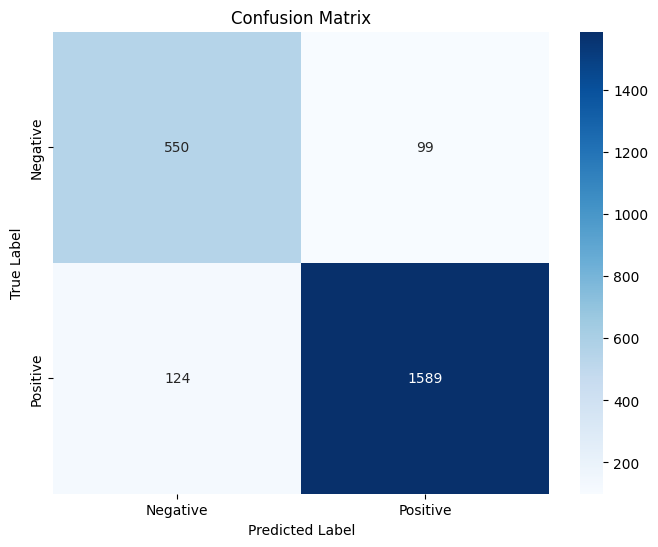

In [63]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [64]:
# Save the model
model.save('rnn_model.h5')

# Download the model file
from google.colab import files # imports the files object from google.colab
files.download('rnn_model.h5') # calls the download function on the files object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>